In [1]:
#load in the setup entry from the lecture
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set seed
np.random.seed(1234)

#pull csv
to = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/DirWk2/coding_discussions_ppol564_fall2021/05_coding_discussion/turnout.csv")

# Train-Test split (just using Pandas)
train = to.sample(frac=.8).reset_index(drop=True)
test = to.drop(train.index).reset_index(drop=True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

Training Data: 1600 
Test Data: 400


In [3]:
# Look at the head of the data
train.head()

,id,age,educate,income,vote,white
0,1749,78,16.0,1.3131,1,1
1,935,72,3.0,0.6765,1,0
2,1034,64,10.0,1.3131,1,1
3,244,80,8.0,1.1839,1,1
4,929,19,14.0,2.9072,1,1


First, we need to isolate Pr(class) components to begin the creation of our bayesian classifier

In [4]:
#limit columns 
train_white = train.drop(columns=['id', 'age', 'educate', 'income'])
test_white = test.drop(columns=['id', 'age', 'educate', 'income'])
y, x1 = train_white.iloc[1,:]
train_white.head()

,vote,white
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1


Now calculate the fraction of those who voted and those who did not

In [5]:
N = train.shape[0]

# Subset the data by class
#call variables "vw" b/c data frame is only vote and white
vw1 = train.query("vote == 1")
vw0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vw_1 = vw1.shape[0]/N
pr_vw_0 = vw0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vw_1}
Pr(vote = 0): {pr_vw_0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



Next calculate the conditional probabilities based on race

In [6]:
# If they voted
w1v1 = vw1.query("white == 1").shape[0]/vw1.shape[0]
w0v1 = vw1.query("white == 0").shape[0]/vw1.shape[0]


# If they did not vote
w1v0 = vw0.query("white == 1").shape[0]/vw0.shape[0]
w0v0 = vw0.query("white == 0").shape[0]/vw0.shape[0]

print(
f"""
Pr(white = 1 |vote = 1): {w1v1}
Pr(white = 0 |vote = 1): {w0v1}
Pr(white = 1 |vote = 0): {w1v0}
Pr(white = 0 |vote = 0): {w0v0}
""")


Pr(white = 1 |vote = 1): 0.8686868686868687
Pr(white = 0 |vote = 1): 0.13131313131313133
Pr(white = 1 |vote = 0): 0.7985436893203883
Pr(white = 0 |vote = 0): 0.20145631067961164



Build a function to calculate the underlying probabilities and the predicition for each observation

In [7]:
def calc_probs(data,outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in 
    the binary data. 
    
    Note that I'm using dictionaries with tuple keys to keep
    track of the variable, it's val, and the outcome, which we're conditioning on. 
    '''
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v != outcome_var]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr 
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs


# Run
class_probs, cond_probs = calc_probs(train_white,outcome_var="vote")

# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.2575, 1: 0.7425}


conditional probabilities

{('white', 0, 0): 0.20145631067961167,
 ('white', 0, 1): 0.13131313131313127,
 ('white', 1, 0): 0.7985436893203883,
 ('white', 1, 1): 0.8686868686868687}


Build a prediction function that combs through the observations in the data and calculates the probabilities and makes a class prediction. 

In [8]:
def predict(data,class_probs,cond_probs):
    '''
    Function calculates the conditiona probability for membership into each class.
    Then returns both the probabilities and the most likely class. 
    '''
    store_preds = []
    for i,row in data.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(1,len(row.index)):
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]     
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run 
preds = predict(train_white, class_probs, cond_probs)

Now test model accuracy

In [9]:
accuracy = sum(train_white.vote == preds.pred)/train.shape[0]
accuracy

0.7425

In [10]:
test_preds = predict(test_white, class_probs, cond_probs)
test_accuracy = sum(test_white.vote == test_preds.pred)/test.shape[0]
test_accuracy

0.7

Overall, we're satisfied with our probibility of 70%+ in predicting our data; it's certainly better than a 50/50 coin toss and we only have two variables

Now we need to construct a model based on the continuous variables within the data

In [15]:
# reformat the data 
train_cont = train.drop(columns=['id', 'white'])
train_cont = train_cont[['vote', 'educate', 'income', 'age']]
y,x1,x2,x3 = train_cont.iloc[1,:]
train_cont.columns = ['y', 'x1', 'x2','x3']
test_cont = test.drop(columns=['id', 'white'])
test_cont = test_cont[['vote', 'educate', 'income', 'age']]
test_cont.columns = ['y', 'x1', 'x2','x3']
test_cont

,y,x1,x2,x3
0,1,16.0,3.9394,31
1,1,12.0,6.3352,53
2,0,12.0,0.8284,65
3,1,12.0,3.3834,34
4,0,12.0,8.7545,28
...,...,...,...,...
395,0,16.0,3.3834,26
396,1,12.0,2.9170,34
397,1,16.0,7.8949,51
398,0,10.0,2.4811,22


calculate the probabilities to find Pr(Class)

In [16]:
#subset into voting and nonvoting portions
y1 = train_cont.query("y == 1")
y0 = train_cont.query("y == 0")

# Class probabilities.
pr_v1 = y1.shape[0]/train_cont.shape[0]
pr_v0 = y0.shape[0]/train_cont.shape[0]

In [17]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("x1",1):{'mean':y1.x1.mean(),'sd':y1.x1.std()},
 ("x1",0):{'mean':y0.x1.mean(),'sd':y0.x1.std()},
 ("x2",1):{'mean':y1.x2.mean(),'sd':y1.x2.std()},
 ("x2",0):{'mean':y0.x2.mean(),'sd':y0.x2.std()},
 ("x3",1):{'mean':y1.x3.mean(),'sd':y1.x3.std()},
 ("x3",0):{'mean':y0.x3.mean(),'sd':y0.x3.std()}
}

# Print
pp.pprint(dist_locs)

{('x1', 0): {'mean': 10.62864077669903, 'sd': 3.304381091983527},
 ('x1', 1): {'mean': 12.558922558922559, 'sd': 3.295714127444309},
 ('x2', 0): {'mean': 2.7381618932038836, 'sd': 2.2429913729337625},
 ('x2', 1): {'mean': 4.229461952861947, 'sd': 2.8482089910676964},
 ('x3', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('x3', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853716}}


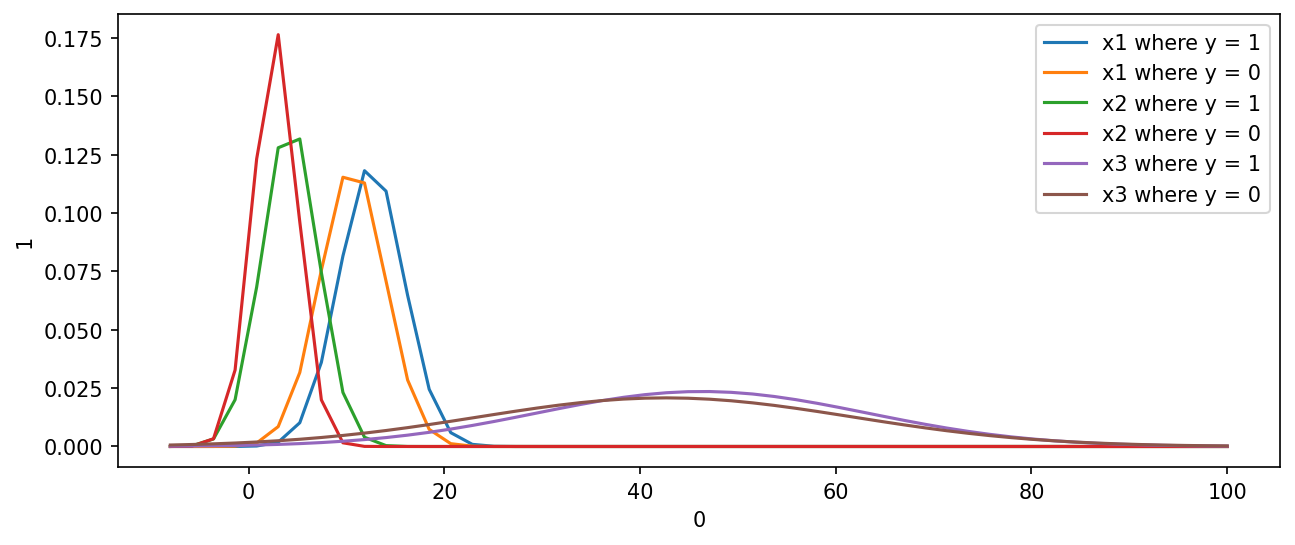

In [18]:
# Plot conditional distributions with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-8,100)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

Here we canse see that when education is lower, the probability distribution of voting is slightly lower; lower income also is a lower probibility of voting; and, lower age is a lower probability of voting

Now, We'll predict a single observation from the continuous data

In [19]:
# Prediction for the 1 class
a = st.norm(dist_locs[("x1",1)]['mean'], dist_locs[("x1",1)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",1)]['mean'], dist_locs[("x2",1)]['sd']).pdf(x2)
c = st.norm(dist_locs[("x3",1)]['mean'], dist_locs[("x3",1)]['sd']).pdf(x2)
d = pr_v1
pr_1 = a * b * c * d

# Prediction for the 0 class
a = st.norm(dist_locs[("x1",0)]['mean'], dist_locs[("x1",0)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",0)]['mean'], dist_locs[("x2",0)]['sd']).pdf(x2)
c = st.norm(dist_locs[("x3",1)]['mean'], dist_locs[("x3",1)]['sd']).pdf(x2)
d = pr_v0
pr_0 = a * b * c * d

print(
f'''
    Pr(y == 1| X): {pr_1}
    Pr(y == 0| X): {pr_0}
''')


    Pr(y == 1| X): 5.347113586961345e-08
    Pr(y == 0| X): 1.5653619194568838e-07



the probability of 1x10^-7 is approximatley double 5x10^-8 so we predict that y=1

Now, establish the predicition function for multiple operations

In [20]:
def predict(data,dist_locs):
    ''''''
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_v0
        pr_1 *= pr_v1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train = predict(train_cont,dist_locs)
#preds_train.head(10)

In [21]:
#check accuracy
accuracy_train = sum(train_cont.y == preds_train.pred)/train.shape[0]
accuracy_train

0.74375

In [22]:
#determine test data accuracy
preds_test = predict(test_cont,dist_locs)
accuracy_test = sum(test_cont.y == preds_test.pred)/test.shape[0]
accuracy_test

0.7225

Once again our predictive model has yielded an accuracy of greater than 70% (though this is a lot more firm since it's not based on a single binary variable). Both results for the continuous variables and the binary variables were more effective than a coin toss!